# Лабораторная работа 1. Pandas, метод ближайших соседей и решающие деревья.

ФИО: Николаев Сергей

Группа: 317

In [1]:
import numpy as np
import pandas as pd

## Часть 1: Pandas

#### Ответьте на вопросы о данных по авиарейсам в США за январь-апрель 2008 года.

Данные: http://stat-computing.org/dataexpo/2009/2008.csv.bz2
(обратите внимание, что распаковывать этот файл не обязательно — функция `pandas.read_csv` умеет читать из архивов автоматически)

Описание: http://stat-computing.org/dataexpo/2009/the-data.html

1. Какая из причин отмены рейса (`CancellationCode`) была самой частой? (расшифровки кодов можно найти в описании данных)
2. Найдите среднее, минимальное и максимальное расстояние, пройденное самолетом.
3. Не выглядит ли подозрительным минимальное пройденное расстояние? В какие дни и на каких рейсах оно было? Какое расстояние было пройдено этими же рейсами в другие дни?
4. Из какого аэропорта было произведено больше всего вылетов? В каком городе он находится?
5. Найдите для каждого аэропорта среднее время полета (`AirTime`) по всем вылетевшим из него рейсам. Какой аэропорт имеет наибольшее значение этого показателя?
6. Найдите аэропорт, у которого наибольшая доля задержанных (`DepDelay > 0`) рейсов. Исключите при этом из рассмотрения аэропорты, из которых было отправлено меньше 1000 рейсов (используйте функцию `filter` после `groupby`).

In [ ]:
data = pd.read_csv('2008.csv')
data = data[(data.Month > 0.5) & (data.Month < 4.5)]

In [4]:
data.shape

(2389217, 29)

In [11]:
data.CancellationCode.value_counts()

A    26075
B    25744
C    12617
D        6
Name: CancellationCode, dtype: int64

A - carrier. По-видимому, проблемы с перевозчиком.

На втором месте погода.

In [6]:
data.Distance.describe()

count    2389217.000000
mean         726.158911
std          557.176261
min           17.000000
25%          325.000000
50%          583.000000
75%          957.000000
max         4962.000000
Name: Distance, dtype: float64

* Минимальное расстояние - 17 миль
* Среднее - 726.16
* Максимальное - 4962

In [14]:
data.loc[data.Distance == 17, ['Month', 'DayofMonth', 'DayofWeek', 'FlightNum']]

,Month,DayofMonth,DayofWeek,FlightNum
1688702,3,8,NaN,1368


In [15]:
data.loc[data.FlightNum == 1368, ['Distance']].describe()

,Distance
count,224.000000
mean,823.321429
std,271.211903
min,17.000000
25%,950.000000
50%,950.000000
75%,950.000000
max,992.000000


In [37]:
data.loc[(data.FlightNum == 1368) & (data.Distance < 290)]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
1688702,2008,3,8,6,NaN,1105,NaN,1128,AA,1368,...,NaN,NaN,1,B,0,NaN,NaN,NaN,NaN,NaN


Больше 75% полетов проходило на расстояние больше 950 миль. Полет на 17 миль был единственным с дальностью полета меньше 290 миль.

In [52]:
data.groupby('Origin').size().argmax()

'ATL'

Город Атланта

In [38]:
data.groupby('Origin')['AirTime'].mean()

Origin
ABE     90.965040
ABI     36.690141
ABQ     91.471470
ABY     34.963415
ACT     30.539860
ACV     53.636610
ACY    108.848214
ADK    149.193548
ADQ     41.964286
AEX     70.034704
AGS     39.355207
AKN     18.500000
ALB    105.005062
ALO     36.679487
AMA     56.313119
ANC    136.479326
ASE     57.575113
ATL     94.947786
ATW     57.029063
AUS     97.524117
AVL     73.666667
AVP     99.535475
AZO     36.399687
BDL    122.260353
BET     56.849398
BFL     64.265053
BGM     67.872247
BGR    105.571965
BHM     84.092114
BIL     70.626725
          ...    
SPI     47.264000
SPS     30.099346
SRQ    109.142414
STL    100.017373
STT    168.322909
STX    177.161491
SUN     47.930337
SUX     45.840000
SWF    140.552967
SYR     85.121257
TEX     92.679389
TLH     65.688283
TOL     56.487666
TPA    120.292551
TRI     48.850153
TUL     83.150345
TUP     42.900000
TUS     95.136052
TVC     47.696909
TWF     42.013774
TXK     47.098734
TYR     31.688380
TYS     83.134138
VLD     45.033233
VPS

In [40]:
data.groupby('Origin')['AirTime'].mean().argmax(), data.groupby('Origin')['AirTime'].mean().max()

('SJU', 209.90795031055902)

In [74]:
data2 = data.groupby('Origin').filter(lambda x: len(x) >= 1000)[['Origin', 'DepDelay']]

In [75]:
size = data2.groupby('Origin').size()
count = data2[data2.DepDelay > 0].groupby('Origin').size()

In [80]:
(count / size).argmax()

'HOU'

In [81]:
(count / size)['HOU']

0.59681640937984082

## Часть 2: метрические методы и категориальные признаки

Все дальнейшие эксперименты предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [16]:
data = pd.read_csv('amazon.csv')
data.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [10]:
data.describe()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
count,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000,32769.000000
mean,0.942110,42923.916171,25988.957979,116952.627788,118301.823156,118912.779914,125916.152644,170178.369648,183703.408893,119789.430132
std,0.233539,34173.892702,35928.031650,10875.563591,4551.588572,18961.322917,31036.465825,69509.462130,100488.407413,5784.275516
min,0.000000,0.000000,25.000000,4292.000000,23779.000000,4674.000000,117879.000000,4673.000000,3130.000000,117880.000000
25%,1.000000,20299.000000,4566.000000,117961.000000,118102.000000,118395.000000,118274.000000,117906.000000,118363.000000,118232.000000
50%,1.000000,35376.000000,13545.000000,117961.000000,118300.000000,118921.000000,118568.000000,128696.000000,119006.000000,118570.000000
75%,1.000000,74189.000000,42034.000000,117961.000000,118386.000000,120535.000000,120006.000000,235280.000000,290919.000000,119348.000000
max,1.000000,312153.000000,311696.000000,311178.000000,286791.000000,286792.000000,311867.000000,311867.000000,308574.000000,270691.000000


In [3]:
data.shape

(32769, 10)

In [4]:
# доля положительных примеров
data.ACTION.mean()

0.9421099209618847

In [5]:
# число значений у признаков
for col_name in data.columns:
    print(col_name, len(data[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [3]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре.

Проще всего будет определить метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), после чего воспользоваться реализацией kNN из sklearn (в этом случае используйте функцию predict_proba). Можно реализовать метод k ближайших соседей и самостоятально — в этом случае учитите, что он должен возвращать оценку вероятности, то есть отношение объектов первого класса среди соседей к числу соседей).

Постарайтесь уделить особое внимание эффективности кода — при реализации метрик "в лоб" вы можете столкнуться с очень большим временем выполнения.

#### Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Мера качества — AUC-ROC.

#### Какая функция расстояния оказалась лучшей?

In [4]:
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

Реализации функций расстояния на категориальных признаках

In [12]:
class matchInd:
    def dist(self, x, y):
        return np.sum(x != y)
    
    
class matchIndCounts:
    def fit(self, X):
        self.nfeatures = X.shape[1]
        self.dicts = []
        for i in range(0, self.nfeatures):
            # создаем словарь (значение признака, log(f(x) + 1))
            values, counts = np.unique(X[:, i], return_counts=True)
            self.dicts.append(dict(np.hstack((values[:, np.newaxis], np.log(counts + 1)[:, np.newaxis]))))
        return None
    
    def dist(self, x, y):
        r = 0
        for i in np.where(x != y)[0]:
            r += self.dicts[i].get(x[i], 1) * self.dicts[i].get(y[i], 1)
        return r

    
class smoothMatch:
    def fit(self, X):
        self.nfeatures = X.shape[1]
        # словарь (значение признака x_j, кумулятивная сумма вариационного ряда из p^2(x_j))
        self.dicts = []
        for i in range(0, self.nfeatures):
            values, counts = np.unique(X[:, i], return_counts=True)
            N = counts.sum()
            if values.shape[0] == 1:
                raise ValueError('Все значения в признаке {} равны.'.format(i))
            ind = np.argsort(counts)
            counts = counts[ind]
            # вычисляем p^2(x_j)
            p2 = counts * (counts - 1) / (N * (N - 1))
            # сумма по всем q: p_j(q) <= p_j(x_j)
            p2sum = np.cumsum(p2)
            self.dicts.append(dict(np.hstack((values[ind, np.newaxis], p2sum[:, np.newaxis]))))
        return None
    
    def dist(self, x, y):
        r = np.sum(x != y)
        for i in np.where(x == y)[0]:
            r += self.dicts[i].get(x[i], 0)
        return r

In [13]:
mic = matchIndCounts()
mic.fit(X_train.values)

sm = smoothMatch()
sm.fit(X_train.values)

mi = matchInd()

Сравнение метрик.

* mi.dist - Индикатор совпадения
* mic.dist - Чем более частые значения оказались при несовпадении, тем больше расстояние
* sm.dist - Сглаженный индикатор совпадения

mi.dist

In [9]:
clf = KNeighborsClassifier(n_neighbors=10, algorithm='brute', metric=mi.dist, n_jobs=-1)
clf.fit(X_train.values, y_train.values)
answer = np.zeros((X_test.values.shape[0], 2))
step = 3000
for j in range(0, X_test.values.shape[0], step):
    if (X_test.values.shape[0] - j) < step:
        step = X_test.values.shape[0] - j
    answer[j:j+step] = clf.predict_proba(X_test.values[j:j+step])
print('AUC_ROC = ', roc_auc_score(y_test.values, answer[:, 1]))

AUC_ROC =  0.829499015542


mic.dist

In [10]:
clf = KNeighborsClassifier(n_neighbors=10, algorithm='brute', metric=mic.dist, n_jobs=-1)
clf.fit(X_train.values, y_train.values)
answer = np.zeros((X_test.values.shape[0], 2))
step = 3000
for j in range(0, X_test.values.shape[0], step):
    if (X_test.values.shape[0] - j) < step:
        step = X_test.values.shape[0] - j
    answer[j:j+step] = clf.predict_proba(X_test.values[j:j+step])
print('AUC_ROC = ', roc_auc_score(y_test.values, answer[:, 1]))

AUC_ROC =  0.818093375774


sm.dist

In [11]:
clf = KNeighborsClassifier(n_neighbors=10, algorithm='brute', metric=sm.dist, n_jobs=-1)
clf.fit(X_train.values, y_train.values)
answer = np.zeros((X_test.values.shape[0], 2))
step = 3000
for j in range(0, X_test.values.shape[0], step):
    if (X_test.values.shape[0] - j) < step:
        step = X_test.values.shape[0] - j
    answer[j:j+step] = clf.predict_proba(X_test.values[j:j+step])
print('AUC_ROC = ', roc_auc_score(y_test.values, answer[:, 1]))

AUC_ROC =  0.833128822008


Лучшим оказался сглаженный индикатор совпадения

#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось получить?

Для подбора можно использовать любые средства из sklearn.

#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

In [27]:
def make_counters(X, y, folding=True):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    new_X = np.zeros((n_samples, 3 * n_features), dtype=float)
    if folding:
        kf = KFold(n_samples, shuffle=True)
    else:
        kf = [(np.arange(n_samples), np.arange(n_samples))]
    for train_ind, test_ind in kf:
        # train_ind - на основе чего строим счетчики
        for i in range(0, n_features):
            uniq_values, counts = np.unique(X[train_ind, i], return_counts=True)
            for j in range(0, uniq_values.shape[0]):
                ind = test_ind[np.where(X[test_ind, i] == uniq_values[j])[0]]
                new_X[ind, i] = counts[j] / train_ind.shape[0]  # учитываем размер train
                successes = np.sum(y[train_ind[np.where(X[train_ind, i] == uniq_values[j])[0]]])
                new_X[ind, n_features + i] = successes / train_ind.shape[0]
                new_X[ind, 2 * n_features + i] = (successes + 1) / (counts[j] + 2)
    return new_X

def make_counters_test(X_train, X_test, y_train):
    n_samples = X_test.shape[0]
    n_features = X_test.shape[1]
    new_X = np.zeros((n_samples, 3 * n_features), dtype=float)
    
    for i in range(0, n_features):
        uniq_values, counts = np.unique(X_train[:, i], return_counts=True)
        for j in range(0, uniq_values.shape[0]):
            ind = np.where(X_test[:, i] == uniq_values[j])[0]
            new_X[ind, i] = counts[j] / X_train.shape[0]
            successes = np.sum(y_train[np.where(X_train[:, i] == uniq_values[j])[0]])
            new_X[ind, n_features + i] = successes / X_train.shape[0]
            new_X[ind, 2 * n_features + i] = (successes + 1) / (counts[j] + 2)
    return new_X    

In [28]:
sc = StandardScaler()
X_train_nf = sc.fit_transform(make_counters(X_train.values, y_train.values, folding=False))
X_train_f = sc.fit_transform(make_counters(X_train.values, y_train.values, folding=True))
X_test_c = sc.fit_transform(make_counters_test(X_train.values, X_test.values, y_train.values))

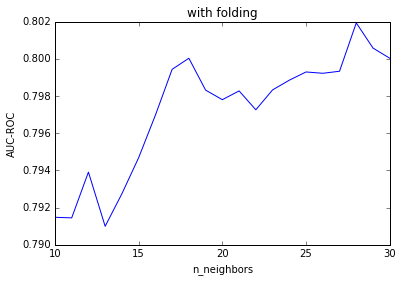

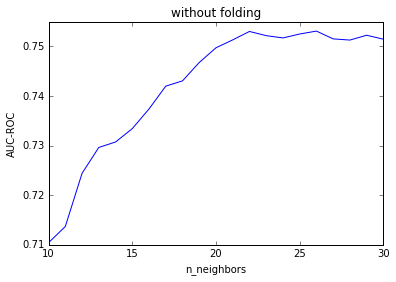

In [29]:
for X in [X_train_f, X_train_nf]:
    scores = []
    for k in range(10, 31):
        clf = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        clf.fit(X, y_train.values)
        answer = np.zeros((X_test_c.shape[0], 2))
        step = 3000
        for j in range(0, X_test_c.shape[0], step):
            if (X_test_c.shape[0] - j) < step:
                step = X_test_c.shape[0] - j
            answer[j:j+step] = clf.predict_proba(X_test_c[j:j+step])
        scores.append(roc_auc_score(y_test.values, answer[:, 1]))
    plt.plot(range(10, 31), scores)
    if X is X_train_f:
        plt.title('with folding')
    else:
        plt.title('without folding')
    plt.xlabel('n_neighbors')
    plt.ylabel('AUC-ROC')
    plt.show()
    

С фолдингом получше

#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [23]:
def make_pairs(X, max_val):
    n_f = X.shape[1]
    new_X = np.zeros((X.shape[0], n_f * (n_f + 1) // 2))
    cur = 0
    i = 1
    while (10 ** i) < (max_val + 1):
        i += 1
    max_val = 10 ** i
    for i in range(0, n_f):
        for j in range(i, n_f):
            # new_x = x[i] * max_val + x[j]
            new_X[:, cur] = X[:, i] * max_val + X[:, j]
            cur += 1
    return new_X

In [30]:
max_val = np.max(data.values)
sc = StandardScaler()
X_train_pairs = make_pairs(X_train.values, max_val)
X_train_nf = sc.fit_transform(make_counters(X_train_pairs, y_train.values, folding=False))
X_train_f = sc.fit_transform(make_counters(X_train_pairs, y_train.values, folding=True))
X_test_c = sc.fit_transform(make_counters_test(X_train_pairs, make_pairs(X_test.values, max_val), y_train.values))

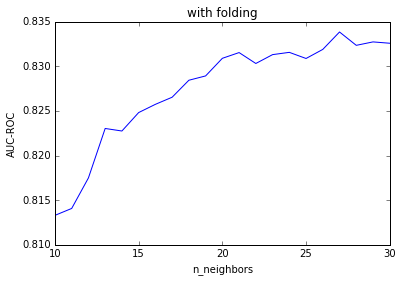

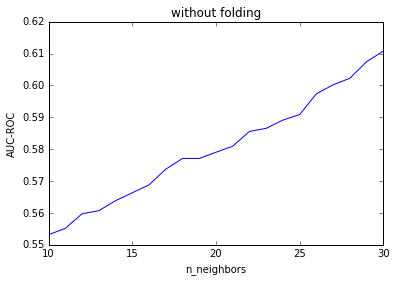

In [32]:
for X in [X_train_f, X_train_nf]:
    scores = []
    for k in range(10, 31):
        clf = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        clf.fit(X, y_train.values)
        answer = np.zeros((X_test_c.shape[0], 2))
        step = 3000
        for j in range(0, X_test_c.shape[0], step):
            if (X_test_c.shape[0] - j) < step:
                step = X_test_c.shape[0] - j
            answer[j:j+step] = clf.predict_proba(X_test_c[j:j+step])
        scores.append(roc_auc_score(y_test.values, answer[:, 1]))
    plt.plot(range(10, 31), scores)
    if X is X_train_f:
        plt.title('with folding')
    else:
        plt.title('without folding')
    plt.xlabel('n_neighbors')
    plt.ylabel('AUC-ROC')
    plt.show()

## Часть 3: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

In [66]:
dtree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
s = 0
for i in range(10):
    dtree.fit(X_train_nf, y_train.values)
    answer = dtree.predict_proba(X_test_c)
    score = roc_auc_score(y_test.values, answer[:, 1])
    print(score)
    s += score
print('mean AUC-ROC =', s / 10)

0.674886566302
0.708694283244
0.706164938205
0.695913583362
0.64611058276
0.699467282142
0.70628651282
0.706853142178
0.711616387072
0.684003314593
mean AUC-ROC = 0.693999659268


Как видно из результатов, AUC-ROC колеблется в пределах 0.64-0.72

#### 2. Настройте случайный лес, подобрав такое число деревьев `n_estimators`, при котором ошибка выходит на асимптоту. Какое качество на тестовой выборке он дает?

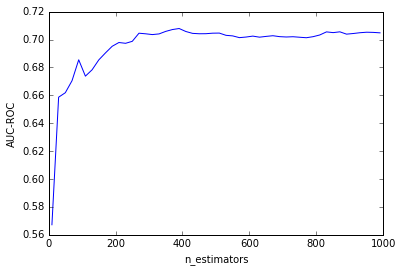

In [79]:
score = []
for i in range(10, 1000, 20):
    rf = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=241)
    rf.fit(X_train_nf, y_train.values)
    answer = rf.predict_proba(X_test_c)
    score.append(roc_auc_score(y_test.values, answer[:, 1]))
plt.plot(range(10, 1000, 20), score)
plt.xlabel('n_estimators')
plt.ylabel('AUC-ROC')
plt.show()

Примерно на 400-х деревьях score выходит на асимптоту.

In [80]:
max(score)

0.7079389571431961

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

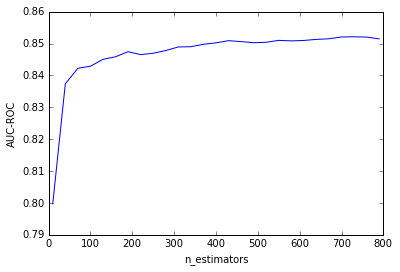

In [82]:
score = []
for i in range(10, 800, 30):
    rf = RandomForestClassifier(n_estimators=i, n_jobs=-1, random_state=241)
    rf.fit(X_train_f, y_train.values)
    answer = rf.predict_proba(X_test_c)
    score.append(roc_auc_score(y_test.values, answer[:, 1]))
plt.plot(range(10, 800, 30), score)
plt.xlabel('n_estimators')
plt.ylabel('AUC-ROC')
plt.show()

In [83]:
max(score)

0.85212627082762749

В случае построения счетчиков без фолдинга происходит переобучение, поэтому на тесте результаты хуже.

Здесь вы можете поделиться своими мыслями о задании.

* Задание вроде как не сложное, но очень много перебора)

А здесь вставьте смешную картинку.

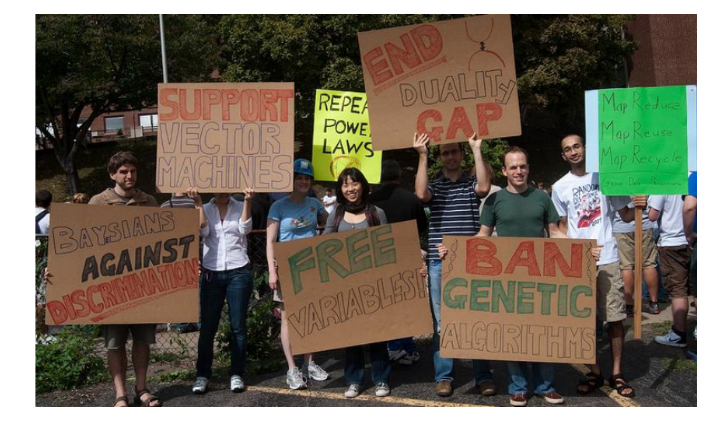

А здесь посоветуйте преподавателям хороший фильм или сериал.

Викинги